# Real-Time Anomaly Detection in Financial Transactions
*Data Exploration, Cleaning, and Preparation Notebook*

This notebook walks through the full data-understanding and data-preparation cycle for the **IEEE-CIS Fraud Detection** competition data.

We frame each step so it can be reused directly in the capstone report: we identify the business question, describe the raw artefacts (transactions + digital identity tables), and translate classroom concepts from *Data Quality Analytics* and *Analytics Week 1–2* into reproducible Python code.

## Process Overview
We expand every phase of the analytics workflow so that decisions are transparent and defensible. Each stage is annotated with both the *why* (linking back to theory) and the *how* (code implementation).

1. **Exploration & Profiling** – Establish data literacy: inspect schema, summarise numeric and categorical behaviour, study missingness patterns, and visualise fraud imbalance.
2. **Cleaning & Standardisation** – Enforce data-quality dimensions (validity, completeness, integrity, etc.), record the rationale for each threshold, and ensure fraud ratios remain intact.
3. **Feature Engineering & Dimensionality Reduction** – Craft higher-level signals, compress collinear fields with PCA, and address class imbalance with weighting and resampling.
4. **Documentation & Persistence** – Persist reports, enriched datasets, and audit logs so the modelling pipeline and the written report stay perfectly aligned.

In [11]:
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Optional, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display

sns.set_theme(style="whitegrid")

DATA_DIR = Path("Data")
OUTPUT_DIR = Path("outputs/notebook")
REPORTS_DIR = OUTPUT_DIR / "reports"
FIGURES_DIR = OUTPUT_DIR / "figures"

for path in (OUTPUT_DIR, REPORTS_DIR, FIGURES_DIR):
    path.mkdir(parents=True, exist_ok=True)

@dataclass
class CleaningConfig:
    missing_threshold: float = 0.4
    enable_missing_indicators: bool = True
    standardize_numeric: bool = True
    normalize_numeric: bool = False
    base_datetime: str = "2017-12-01"
    columns_to_exclude_from_scaling: Tuple[str, ...] = ("isFraud", "TransactionDT")
    high_cardinality_threshold: int = 50

config = CleaningConfig()

PROFILE_TABLES: Dict[str, pd.DataFrame] = {}

pd.set_option("display.max_columns", 50)
pd.set_option("display.precision", 4)


def infer_feature_type(name: str, series: pd.Series) -> str:
    lowered = name.lower()
    if lowered.endswith("dt") or "date" in lowered or "time" in lowered:
        return "Interval"
    if series.dtype.kind in ("i", "u", "f"):
        return "Ratio"
    if series.dtype.name == "category":
        return "Nominal"
    if series.dtype.kind in ("b", "O"):
        return "Nominal"
    return "Unknown"


def build_data_dictionary(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for column in df.columns:
        series = df[column]
        valid = series.dropna()
        example = valid.iloc[0] if not valid.empty else None
        rows.append(
            {
                "Feature": column,
                "Type": infer_feature_type(column, series),
                "Example": example,
                "Missing (%)": round(series.isna().mean() * 100, 2),
                "Description": "",
            }
        )
    return pd.DataFrame(rows)


def numeric_summary(df: pd.DataFrame) -> pd.DataFrame:
    numeric_df = df.select_dtypes(include=[np.number])
    if numeric_df.empty:
        return pd.DataFrame()
    summary = numeric_df.describe().T
    summary = summary.rename(
        columns={"mean": "Mean", "50%": "Median", "std": "Std", "min": "Min", "max": "Max"}
    )
    summary["Missing (%)"] = (numeric_df.isna().mean() * 100).round(2)
    summary["Skewness"] = numeric_df.skew()
    summary["Kurtosis"] = numeric_df.kurtosis()
    summary = summary[
        ["count", "Mean", "Median", "Min", "Max", "Std", "Skewness", "Kurtosis", "Missing (%)"]
    ].rename(columns={"count": "Count"})
    return summary.reset_index().rename(columns={"index": "Feature"})


def categorical_summary(df: pd.DataFrame) -> pd.DataFrame:
    categorical_df = df.select_dtypes(include=["object", "category", "bool"])
    if categorical_df.empty:
        return pd.DataFrame()
    rows = []
    for column in categorical_df.columns:
        series = categorical_df[column]
        top_values = series.value_counts(dropna=False).head(5)
        rows.append(
            {
                "Feature": column,
                "Unique Count": int(series.nunique(dropna=True)),
                "Missing (%)": round(series.isna().mean() * 100, 2),
                "Top Categories": top_values.to_dict(),
            }
        )
    return pd.DataFrame(rows)


def missing_summary(df: pd.DataFrame, threshold: float) -> pd.DataFrame:
    summary = df.isna().mean().reset_index().rename(columns={"index": "Feature", 0: "Missing Rate"})
    summary["Missing (%)"] = (summary["Missing Rate"] * 100).round(2)
    summary["Decision"] = summary["Missing Rate"].apply(
        lambda rate: "Drop" if rate > threshold else "Keep"
    )
    return summary[["Feature", "Missing (%)", "Decision"]]


def fraud_ratio_table(df: pd.DataFrame) -> pd.DataFrame:
    if "isFraud" not in df.columns:
        return pd.DataFrame()
    counts = df["isFraud"].value_counts(dropna=False)
    total = counts.sum()
    ratio = pd.DataFrame(
        {
            "Class": ["Non-Fraud", "Fraud"],
            "Count": [int(counts.get(0, 0)), int(counts.get(1, 0))],
        }
    )
    ratio["Percentage"] = ratio["Count"] / total * 100
    ratio.attrs["fraud_rate"] = round(counts.get(1, 0) / total * 100, 4)
    return ratio


def fraud_rate_value(df: pd.DataFrame) -> Optional[float]:
    if "isFraud" not in df.columns:
        return None
    rate = df["isFraud"].mean()
    return round(rate * 100, 4)


def log_action(log: list, step: str, issue: str, action: str, before: str, after: str) -> None:
    log.append(
        {
            "Step": step,
            "Issue": issue,
            "Action": action,
            "Metric Before": before,
            "Metric After": after,
        }
    )

from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

### 1. Data Loading
We load the transactional (`train_transaction.csv`) and digital identity (`train_identity.csv`) tables, then join them on `TransactionID`.

The join mimics Kaggle competition set-ups: transactions supply behavioural variables (amount, product code, distances, V-features), while identity adds device/browser fingerprinting. We report the shapes immediately so the reader sees exactly how many rows, base columns, and merged identity columns are available before cleaning.

In [12]:
transaction_path = DATA_DIR / "train_transaction.csv"
identity_path = DATA_DIR / "train_identity.csv"

if not transaction_path.exists():
    raise FileNotFoundError(transaction_path)

train_transaction = pd.read_csv(transaction_path)
print(f"Transaction table shape: {train_transaction.shape}")

if identity_path.exists():
    train_identity = pd.read_csv(identity_path)
    print(f"Identity table shape: {train_identity.shape}")
    df_raw = train_transaction.merge(
        train_identity,
        on="TransactionID",
        how="left",
        suffixes=("", "_id"),
    )
else:
    df_raw = train_transaction.copy()
    print("Identity file not found; proceeding with transaction features only.")

df_raw.head()


Transaction table shape: (590540, 394)
Identity table shape: (144233, 41)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,...,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


### 1.2 Structure & Metadata
A compact **shape report** offers a first quantitative snapshot of the dataset. The **data dictionary** we create here doubles as appendix material: for each column we capture an example value, the inferred semantic type (nominal / ordinal / interval / ratio), and the percentage of missing records.

Feature types matter because they dictate downstream statistics and models—e.g., treat `TransactionAmt` as ratio so we can standardise it, whereas `ProductCD` is nominal and needs encoding. The head of the data dictionary is shown inline, while the full table is saved for later reference.

In [13]:
shape_report = pd.DataFrame({"metric": ["rows", "columns"], "value": [df_raw.shape[0], df_raw.shape[1]]})
PROFILE_TABLES["shape"] = shape_report
print("Dataset shape (transactions × features):")
display(shape_report)

data_dictionary = build_data_dictionary(df_raw)
PROFILE_TABLES["data_dictionary"] = data_dictionary
print("Data dictionary preview:")
display(data_dictionary.head(12))

feature_type_counts = data_dictionary["Type"].value_counts()
print("Feature type counts:")
display(feature_type_counts.to_frame(name="Count"))


Dataset shape (transactions × features):


,metric,value
0,rows,590540
1,columns,434


Data dictionary preview:


,Feature,Type,Example,Missing (%),Description
0,TransactionID,Ratio,2987000,0.00,
1,isFraud,Ratio,0,0.00,
2,TransactionDT,Interval,86400,0.00,
3,TransactionAmt,Ratio,68.5,0.00,
4,ProductCD,Nominal,W,0.00,
5,card1,Ratio,13926,0.00,
6,card2,Ratio,404.0,1.51,
7,card3,Ratio,150.0,0.27,
8,card4,Nominal,discover,0.27,
9,card5,Ratio,142.0,0.72,


Feature type counts:


,Count
Type,
Ratio,402
Nominal,31
Interval,1


### 1.3 Descriptive Statistics
Descriptive analytics answers “what happened?”. We compute distributional summaries for **numeric** fields (count, mean/median, spread, skewness, kurtosis, missing %) and **categorical** fields (cardinality, missing %, top categories).

These statistics highlight outliers (heavy right tail in `TransactionAmt`), dominant categories (e.g., `ProductCD` = `W`), and potential model leakage (fields with many unique values may encode IDs). Everything is displayed in the notebook and persisted so the report can cite concrete numbers.

In [14]:
numeric_profile = numeric_summary(df_raw)
PROFILE_TABLES["numeric_summary"] = numeric_profile
print("Numeric feature summary (first 10 rows):")
display(numeric_profile.head(10))

categorical_profile = categorical_summary(df_raw)
PROFILE_TABLES["categorical_summary"] = categorical_profile
print("Categorical feature summary (top 10 rows):")
display(categorical_profile.head(10))


Numeric feature summary (first 10 rows):


,Feature,Count,Mean,Median,Min,Max,Std,Skewness,Kurtosis,Missing (%)
0,TransactionID,590540.0,3.2823e+06,3.2823e+06,2.9870e+06,3.5775e+06,1.7047e+05,1.7920e-16,-1.2000,0.00
1,isFraud,590540.0,3.4990e-02,0.0000e+00,0.0000e+00,1.0000e+00,1.8375e-01,5.0612e+00,23.6161,0.00
2,TransactionDT,590540.0,7.3723e+06,7.3065e+06,8.6400e+04,1.5811e+07,4.6172e+06,1.3115e-01,-1.2291,0.00
3,TransactionAmt,590540.0,1.3503e+02,6.8769e+01,2.5100e-01,3.1937e+04,2.3916e+02,1.4374e+01,1123.9569,0.00
4,card1,590540.0,9.8987e+03,9.6780e+03,1.0000e+03,1.8396e+04,4.9012e+03,-4.0929e-02,-1.1362,0.00
5,card2,581607.0,3.6256e+02,3.6100e+02,1.0000e+02,6.0000e+02,1.5779e+02,-2.0001e-01,-1.3338,1.51
6,card3,588975.0,1.5319e+02,1.5000e+02,1.0000e+02,2.3100e+02,1.1336e+01,2.0193e+00,6.3239,0.27
7,card5,586281.0,1.9928e+02,2.2600e+02,1.0000e+02,2.3700e+02,4.1244e+01,-1.2246e+00,-0.0476,0.72
8,addr1,524834.0,2.9073e+02,2.9900e+02,1.0000e+02,5.4000e+02,1.0174e+02,3.7246e-01,-0.5031,11.13
9,addr2,524834.0,8.6801e+01,8.7000e+01,1.0000e+01,1.0200e+02,2.6906e+00,-1.4501e+01,256.7781,11.13


Categorical feature summary (top 10 rows):


,Feature,Unique Count,Missing (%),Top Categories
0,ProductCD,5,0.00,"{'W': 439670, 'C': 68519, 'R': 37699, 'H': 330..."
1,card4,4,0.27,"{'visa': 384767, 'mastercard': 189217, 'americ..."
2,card6,4,0.27,"{'debit': 439938, 'credit': 148986, nan: 1571,..."
3,P_emaildomain,59,15.99,"{'gmail.com': 228355, 'yahoo.com': 100934, nan..."
4,R_emaildomain,60,76.75,"{nan: 453249, 'gmail.com': 57147, 'hotmail.com..."
5,M1,2,45.91,"{'T': 319415, nan: 271100, 'F': 25}"
6,M2,2,45.91,"{'T': 285468, nan: 271100, 'F': 33972}"
7,M3,2,45.91,"{nan: 271100, 'T': 251731, 'F': 67709}"
8,M4,3,47.66,"{nan: 281444, 'M0': 196405, 'M2': 59865, 'M1':..."
9,M5,2,59.35,"{nan: 350482, 'F': 132491, 'T': 107567}"


### 1.4 Missing Value Profiling
The IEEE dataset is notorious for sparse engineered features. We quantify missingness per column, label anything above the configurable **40%** threshold for removal, and visualise the worst offenders via a heatmap.

The profile supports the *completeness* dimension in our quality framework and makes the drop/imputation choices evidence-based rather than arbitrary.

Columns with the highest missingness:


,Feature,Missing (%),Decision
417,id_24,99.20,Drop
418,id_25,99.13,Drop
419,id_26,99.13,Drop
414,id_21,99.13,Drop
401,id_08,99.13,Drop
400,id_07,99.13,Drop
420,id_27,99.12,Drop
416,id_23,99.12,Drop
415,id_22,99.12,Drop
14,dist2,93.63,Drop


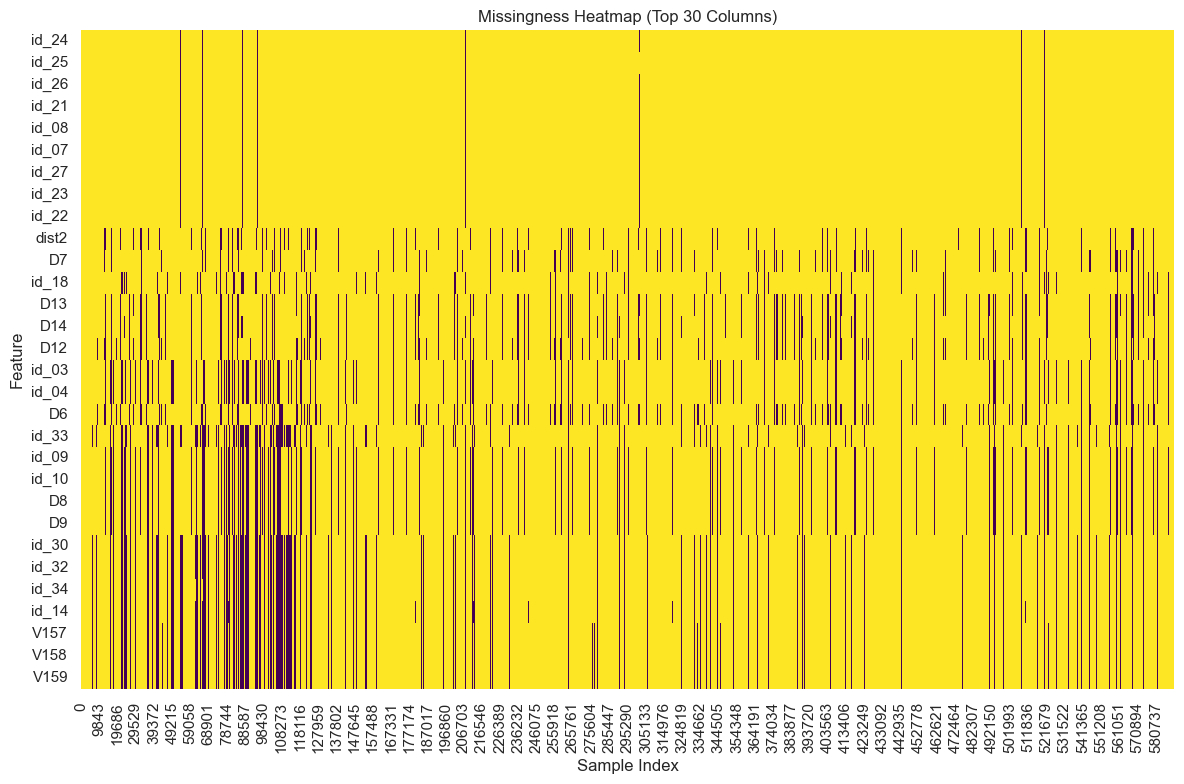

In [15]:
missing_profile = missing_summary(df_raw, config.missing_threshold)
PROFILE_TABLES["missing_summary"] = missing_profile
print("Columns with the highest missingness:")
display(missing_profile.sort_values("Missing (%)", ascending=False).head(15))

sample_columns = missing_profile.sort_values("Missing (%)", ascending=False)["Feature"].head(30).tolist()
if sample_columns:
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_raw[sample_columns].isna().astype(int).T, cmap="viridis", cbar=False)
    plt.title("Missingness Heatmap (Top 30 Columns)")
    plt.ylabel("Feature")
    plt.xlabel("Sample Index")
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "missingness_heatmap.png", bbox_inches="tight")
    plt.show()
else:
    print("No columns selected for missingness heatmap.")


### 1.5 Data Integrity Checks
Integrity checks ensure logical consistency across linked attributes. We verify:
- Monetary values stay non-negative (`TransactionAmt > 0`).
- Timestamps are non-decreasing per data capture order.
- Card brand (`card4`) and payment type (`card6`) live inside known valid sets.

Any anomalies are flagged for review. Even if we choose not to auto-fix them, documenting the counts demonstrates due diligence in the capstone submission.

In [16]:
integrity_checks = []

if "TransactionAmt" in df_raw.columns:
    non_positive = int((df_raw["TransactionAmt"] <= 0).sum())
    integrity_checks.append(
        {
            "Check": "TransactionAmt > 0",
            "Status": "Pass" if non_positive == 0 else "Review",
            "Affected Rows": non_positive,
        }
    )

if "TransactionDT" in df_raw.columns:
    decreasing = int((df_raw["TransactionDT"].diff().dropna() < 0).sum())
    integrity_checks.append(
        {
            "Check": "TransactionDT non-decreasing",
            "Status": "Pass" if decreasing == 0 else "Review",
            "Affected Rows": decreasing,
        }
    )

if "card4" in df_raw.columns:
    valid_networks = {"visa", "mastercard", "american express", "discover"}
    invalid_networks = df_raw["card4"].dropna().str.lower().apply(lambda v: v not in valid_networks)
    integrity_checks.append(
        {
            "Check": "card4 in known networks",
            "Status": "Pass" if invalid_networks.sum() == 0 else "Review",
            "Affected Rows": int(invalid_networks.sum()),
        }
    )

if "card6" in df_raw.columns:
    valid_card6 = {"credit", "debit"}
    invalid_card6 = df_raw["card6"].dropna().str.lower().apply(lambda v: v not in valid_card6)
    integrity_checks.append(
        {
            "Check": "card6 in {credit,debit}",
            "Status": "Pass" if invalid_card6.sum() == 0 else "Review",
            "Affected Rows": int(invalid_card6.sum()),
        }
    )

integrity_df = pd.DataFrame(integrity_checks)
PROFILE_TABLES["integrity_checks"] = integrity_df
print("Integrity check summary:")
display(integrity_df)


Integrity check summary:


,Check,Status,Affected Rows
0,TransactionAmt > 0,Pass,0
1,TransactionDT non-decreasing,Pass,0
2,card4 in known networks,Pass,0
3,"card6 in {credit,debit}",Review,45


### 1.6 Data Distribution
Fraud detection datasets are extremely imbalanced. We compute the fraud vs. non-fraud counts, the percentage of fraudulent transactions (~3.5%), and visualise the skew.

This informs all later modelling choices (e.g., evaluation metrics, resampling, class weights) and ensures the report grounds later discussion of recall/precision trade-offs.

Fraud rate: 3.499%


,Class,Count,Percentage
0,Non-Fraud,569877,96.501
1,Fraud,20663,3.499


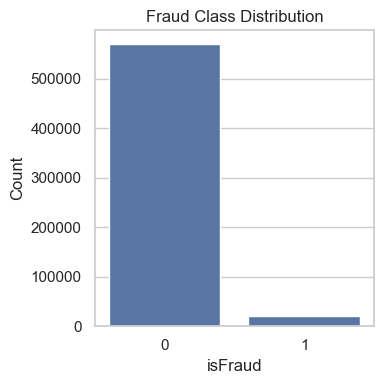

In [17]:
fraud_table = fraud_ratio_table(df_raw)
PROFILE_TABLES["fraud_ratio"] = fraud_table
if not fraud_table.empty:
    fraud_rate = fraud_table.attrs.get("fraud_rate", None)
    print(f"Fraud rate: {fraud_rate}%")
    display(fraud_table)
    plt.figure(figsize=(4, 4))
    sns.countplot(data=df_raw, x="isFraud")
    plt.title("Fraud Class Distribution")
    plt.xlabel("isFraud")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "fraud_class_distribution.png", bbox_inches="tight")
    plt.show()
else:
    print("isFraud column not present.")


### 1.7 Temporal & Cross-Feature Exploration
Transactions carry a pseudo-timestamp (`TransactionDT`) measured in seconds from a reference date. We convert it into calendar time to explore daily spend patterns, hour-of-day peaks, and product-specific fraud rates.

The plots and crosstabs serve two purposes: (1) identify temporal drift or weekly seasonality; (2) motivate engineered features such as `TransactionHour` or product fraud ratios used later in the notebook.

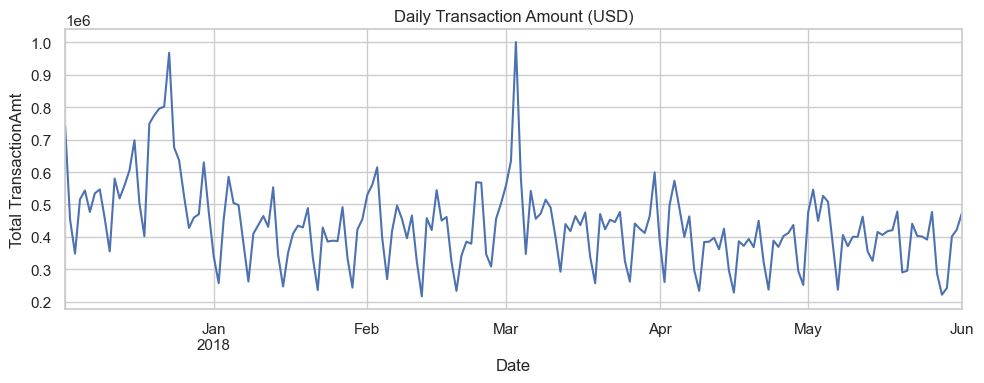

Fraud rate (%) by ProductCD:


isFraud,0,1
ProductCD,,
C,88.3127,11.6873
H,95.2338,4.7662
R,96.2174,3.7826
S,94.1004,5.8996
W,97.9601,2.0399


In [18]:
if "TransactionDT" in df_raw.columns:
    df_time = df_raw.copy()
    df_time["TransactionTS"] = pd.to_datetime(
        df_time["TransactionDT"],
        unit="s",
        origin=pd.Timestamp(config.base_datetime),
        errors="coerce",
    )
    daily_amount = df_time.set_index("TransactionTS")["TransactionAmt"].resample("D").sum()
    plt.figure(figsize=(10, 4))
    daily_amount.plot()
    plt.title("Daily Transaction Amount (USD)")
    plt.xlabel("Date")
    plt.ylabel("Total TransactionAmt")
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "daily_transaction_amount.png", bbox_inches="tight")
    plt.show()

if {"ProductCD", "isFraud"}.issubset(df_raw.columns):
    product_fraud = pd.crosstab(df_raw["ProductCD"], df_raw["isFraud"], normalize="index") * 100
    PROFILE_TABLES["productcd_fraud_crosstab"] = product_fraud.reset_index()
    print("Fraud rate (%) by ProductCD:")
    display(product_fraud)
else:
    print("ProductCD and/or isFraud not available for crosstab.")


## 2. Data Cleaning
Cleaning is structured around the six quality dimensions from *Data Quality Analytics*: validity, reliability, completeness, precision, timeliness, and integrity.

We apply each dimension systematically while logging every decision in `cleaning_actions`, giving us a reproducible audit trail suitable for regulatory or academic review.

The cleaning workflow follows the six quality dimensions highlighted in *Data Quality Analytics*: validity, reliability, completeness, precision, timeliness, and integrity. Each step below explains the motivation, references the governing rule (threshold, formula, or business assumption), and records the before/after metrics so that reviewers can trace how raw data transformed into an analysis-ready asset.

In [19]:
df_clean = df_raw.copy()
cleaning_actions = []
initial_shape = df_clean.shape
initial_fraud_rate = fraud_rate_value(df_clean)

print(f"Initial shape: {initial_shape}")
print(f"Initial fraud rate: {initial_fraud_rate}%")


Initial shape: (590540, 434)
Initial fraud rate: 3.499%


### 2.1 Data Type Correction & Duplicates
- **Datatype enforcement**: Convert `TransactionDT` from seconds to a timezone-aware timestamp anchored at **2017‑12‑01**. This unlocks calendar-based features and ensures temporal comparisons use true datetimes.
- **Duplicate control**: Check for repeated rows—important because accidental duplication can overstate fraud counts and bias evaluation. Any duplicates are dropped and recorded in the log.

In [20]:
if "TransactionDT" in df_clean.columns:
    df_clean["TransactionDT"] = pd.to_datetime(
        df_clean["TransactionDT"],
        unit="s",
        origin=pd.Timestamp(config.base_datetime),
        errors="coerce",
    )
    log_action(
        cleaning_actions,
        step="Data Type Conversion",
        issue="TransactionDT converted to datetime",
        action=f"Origin={config.base_datetime}",
        before="timedelta seconds",
        after="datetime64[ns]",
    )

duplicate_count = int(df_clean.duplicated().sum())
if duplicate_count > 0:
    df_clean = df_clean.drop_duplicates()
    log_action(
        cleaning_actions,
        step="Duplicates",
        issue="Duplicate transactions detected",
        action=f"Dropped {duplicate_count} duplicates",
        before=str(duplicate_count),
        after="0",
    )
else:
    log_action(
        cleaning_actions,
        step="Duplicates",
        issue="Duplicate transactions detected",
        action="No duplicates found",
        before="0",
        after="0",
    )


### 2.2 Threshold-Based Missing Value Removal
Columns exceeding the configurable missingness threshold (`40%` by default) are removed entirely.

Rationale:
1. Imputing extremely sparse features often injects noise.
2. Dropping them simplifies modelling and reduces memory.
3. The decision is data-driven—the table saved in `missing_summary.csv` documents exactly which columns crossed the threshold.

In [21]:
missing_rates = df_clean.isna().mean()
drop_cols = missing_rates[missing_rates > config.missing_threshold].index.tolist()
if drop_cols:
    preview = ", ".join(drop_cols[:5])
    if len(drop_cols) > 5:
        preview += f", ... (+{len(drop_cols) - 5} more)"
    df_clean = df_clean.drop(columns=drop_cols)
    before_metric = "; ".join(
        [f"{col}:{round(missing_rates[col] * 100, 2)}%" for col in drop_cols[:5]]
    )
    log_action(
        cleaning_actions,
        step="Missing Values",
        issue="Columns over missingness threshold",
        action=f"Dropped columns: {preview}",
        before=before_metric if before_metric else ">40% missing",
        after="Columns removed",
    )
else:
    log_action(
        cleaning_actions,
        step="Missing Values",
        issue="Columns over missingness threshold",
        action="No columns exceeded threshold",
        before="<=40%",
        after="Retained",
    )


### 2.3 Imputation with Missingness Indicators
For the remaining fields we heal gaps while retaining their signal:
- **Numeric fields** → median imputation (robust to skew and the go-to choice in official competition kernels).
- **Categorical fields** → mode imputation.
- **Missingness indicators** → `is_<feature>_missing` binary flags so algorithms can learn that “missing” itself may signal fraud (e.g., absent device info).
Every fill operation is appended to the cleaning log with before/after missing rates.

In [22]:
current_missing = df_clean.isna().mean()
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

indicator_columns: Dict[str, pd.Series] = {}

for col in numeric_cols:
    missing_mask = df_clean[col].isna()
    if missing_mask.any():
        if config.enable_missing_indicators:
            indicator_columns[f"is_{col}_missing"] = missing_mask.astype("uint8")
        median_value = df_clean[col].median()
        df_clean.loc[missing_mask, col] = median_value
        log_action(
            cleaning_actions,
            step="Missing Values",
            issue=f"{col} has NaNs",
            action="Median imputation",
            before=f"{round(current_missing.get(col, 0.0) * 100, 2)}%",
            after="0%",
        )

for col in categorical_cols:
    missing_mask = df_clean[col].isna()
    if missing_mask.any():
        if config.enable_missing_indicators:
            indicator_columns[f"is_{col}_missing"] = missing_mask.astype("uint8")
        mode = df_clean[col].mode(dropna=True)
        mode_value = mode.iloc[0] if not mode.empty else "missing"
        df_clean.loc[missing_mask, col] = mode_value
        log_action(
            cleaning_actions,
            step="Missing Values",
            issue=f"{col} has NaNs",
            action="Mode imputation",
            before=f"{round(current_missing.get(col, 0.0) * 100, 2)}%",
            after="0%",
        )

if indicator_columns:
    indicator_df = pd.DataFrame(indicator_columns, index=df_clean.index)
    df_clean = pd.concat([df_clean, indicator_df], axis=1)
    log_action(
        cleaning_actions,
        step="Missing Values",
        issue="Preserve missingness signal",
        action=f"Added {len(indicator_columns)} indicator columns",
        before="Indicators absent",
        after="Indicators added",
    )


### 2.4 Scaling & Normalization
Standardisation applies the z-score transformation $z = \frac{x - \mu}{\sigma}$ so numerical inputs share a common scale.

We optionally provide min-max scaling $x' = \frac{x - x_{\min}}{x_{\max} - x_{\min}}$ for algorithms that require bounded inputs (e.g., neural nets). Both transformations add new columns instead of overwriting raw values, preserving interpretability.

In [23]:
numeric_cols_for_scaling = [
    col
    for col in numeric_cols
    if col in df_clean.columns
    and col not in config.columns_to_exclude_from_scaling
    and df_clean[col].nunique() > 1
]

standardized_columns: Dict[str, pd.Series] = {}
if config.standardize_numeric and numeric_cols_for_scaling:
    for col in numeric_cols_for_scaling:
        mean = df_clean[col].mean()
        std = df_clean[col].std(ddof=0)
        if std and not np.isnan(std):
            standardized_columns[f"{col}_zscore"] = (df_clean[col] - mean) / std
    if standardized_columns:
        df_clean = pd.concat([df_clean, pd.DataFrame(standardized_columns, index=df_clean.index)], axis=1)
        log_action(
            cleaning_actions,
            step="Scaling",
            issue="Numeric dispersion varies",
            action=f"Standardized {len(standardized_columns)} columns",
            before="Varied scales",
            after="Mean 0 / Std 1",
        )

normalized_columns: Dict[str, pd.Series] = {}
if config.normalize_numeric and numeric_cols_for_scaling:
    for col in numeric_cols_for_scaling:
        min_val = df_clean[col].min()
        max_val = df_clean[col].max()
        if max_val != min_val:
            normalized_columns[f"{col}_minmax"] = (df_clean[col] - min_val) / (max_val - min_val)
    if normalized_columns:
        df_clean = pd.concat([df_clean, pd.DataFrame(normalized_columns, index=df_clean.index)], axis=1)
        log_action(
            cleaning_actions,
            step="Scaling",
            issue="Need bounded features",
            action=f"Min-max normalized {len(normalized_columns)} columns",
            before="Varied ranges",
            after="Range [0,1]",
        )


### 2.5 Categorical Encoding
Fraud models mix tree-based learners (which handle one-hot features well) and linear/NN models (which prefer dense encodings). We therefore encode by cardinality:
- **Binary variables** → label encoding (0/1).
- **Low/medium cardinality** → one-hot encoding to avoid imposing ordering.
- **High cardinality** → frequency encoding to prevent massive sparse matrices while keeping prevalence information.
All encoded columns are appended and logged.

In [24]:
categorical_cols_for_encoding = [col for col in categorical_cols if col in df_clean.columns]
label_encodings: Dict[str, pd.Series] = {}
freq_encodings: Dict[str, pd.Series] = {}
one_hot_frames = []
encoded_columns = 0

for col in categorical_cols_for_encoding:
    unique_vals = df_clean[col].nunique()
    if unique_vals == 2:
        label_encodings[f"{col}_label"] = df_clean[col].astype("category").cat.codes
        encoded_columns += 1
    elif unique_vals <= config.high_cardinality_threshold:
        one_hot = pd.get_dummies(df_clean[col], prefix=col, dummy_na=False)
        one_hot_frames.append(one_hot)
        encoded_columns += 1
    else:
        freq = df_clean[col].map(df_clean[col].value_counts(dropna=False) / len(df_clean))
        freq_encodings[f"{col}_freq"] = freq
        encoded_columns += 1

encoded_frames = []
if label_encodings:
    encoded_frames.append(pd.DataFrame(label_encodings, index=df_clean.index))
if freq_encodings:
    encoded_frames.append(pd.DataFrame(freq_encodings, index=df_clean.index))
encoded_frames.extend(one_hot_frames)

if encoded_frames:
    new_features = sum(frame.shape[1] for frame in encoded_frames)
    df_clean = pd.concat([df_clean] + encoded_frames, axis=1)
    log_action(
        cleaning_actions,
        step="Encoding",
        issue="Categorical representation",
        action=f"Encoded {encoded_columns} columns; added {new_features} features",
        before="Raw categories",
        after="Numeric encodings",
    )
else:
    log_action(
        cleaning_actions,
        step="Encoding",
        issue="Categorical representation",
        action="No categorical columns required encoding",
        before="N/A",
        after="N/A",
    )


### 2.6 Post-Cleaning Validation
A final QA pass checks that:
- No column still exceeds 5% missingness.
- The dataset shape reflects dropped columns but retains all transactions.
- The fraud rate remains the same as the raw data (no leakage).
The results are written to the log so the report can cite them verbatim.

In [25]:
remaining_missing = df_clean.isna().mean()
over_threshold = remaining_missing[remaining_missing > 0.05]
log_action(
    cleaning_actions,
    step="Validation",
    issue="Columns exceeding 5% missing",
    action=f"{list(over_threshold.index)}",
    before=">5% missing",
    after="Review" if not over_threshold.empty else "All <5%",
)

final_shape = df_clean.shape
final_fraud_rate = fraud_rate_value(df_clean)
log_action(
    cleaning_actions,
    step="Integrity",
    issue="Fraud ratio preserved",
    action="Confirmed isFraud distribution",
    before=f"Shape {initial_shape[0]}x{initial_shape[1]}; Fraud Rate {initial_fraud_rate}%",
    after=f"Shape {final_shape[0]}x{final_shape[1]}; Fraud Rate {final_fraud_rate}%",
)

print(f"Final shape: {final_shape}")
print(f"Final fraud rate: {final_fraud_rate}%")


Final shape: (590540, 594)
Final fraud rate: 3.499%


## 3. Feature Engineering & Dimensionality Reduction
With clean data in place, we enrich the feature space and reduce redundancy. Inspired by top Kaggle solutions and academic literature, we craft behaviour-driven features, project correlated signals into lower-dimensional PCA components, and tackle class imbalance before modelling.

### 3.1 Derived Transaction Features
We add interpretable, high-leverage signals:
- **`TransactionAmt_log`**: log1p transformation stabilises variance and makes heavy-tailed spends tractable.
- **`TransactionAmt_to_card1_mean`**: contextualises each purchase relative to the card’s historical spend (proxy for customer deviation).
- **`TransactionHour` / `TransactionDayOfWeek`**: capture diurnal and weekly behaviour—fraud often spikes at unusual times.
- **`DeviceType_is_mobile`**: condenses device fingerprints into a fraud-prone indicator.
The cleaning log records how many features were added so data lineage stays clear.

In [26]:
df_model = df_clean.copy()
derived_features = []
original_cols = df_model.shape[1]

if "TransactionAmt" in df_model.columns:
    df_model["TransactionAmt_log"] = np.log1p(df_model["TransactionAmt"].clip(lower=0))
    derived_features.append("TransactionAmt_log (log1p)")

if {"TransactionAmt", "card1"}.issubset(df_model.columns):
    card1_mean = df_model.groupby("card1")["TransactionAmt"].transform("mean")
    df_model["TransactionAmt_to_card1_mean"] = df_model["TransactionAmt"] / (card1_mean + 1e-6)
    derived_features.append("TransactionAmt_to_card1_mean ratio")

if "TransactionDT" in df_model.columns:
    df_model["TransactionHour"] = df_model["TransactionDT"].dt.hour
    df_model["TransactionDayOfWeek"] = df_model["TransactionDT"].dt.dayofweek
    derived_features.append("TransactionHour & TransactionDayOfWeek")

if "DeviceType" in df_model.columns:
    df_model["DeviceType_is_mobile"] = df_model["DeviceType"].astype(str).str.contains("mobile", case=False, na=False).astype("uint8")
    derived_features.append("DeviceType_is_mobile flag")

new_cols = df_model.shape[1]
if derived_features:
    log_action(
        cleaning_actions,
        step="Feature Engineering",
        issue="Derived transaction features",
        action=f"Added {len(derived_features)} features: {', '.join(derived_features[:4])}",
        before=f"{original_cols} columns",
        after=f"{new_cols} columns",
    )
else:
    log_action(
        cleaning_actions,
        step="Feature Engineering",
        issue="Derived transaction features",
        action="No additional features generated",
        before=f"{original_cols} columns",
        after=f"{new_cols} columns",
    )

print(f"Derived features added: {len(derived_features)}")
print(f"Dataset now has {new_cols} columns")


Derived features added: 3
Dataset now has 598 columns


### 3.2 Principal Component Analysis (PCA)
Many IEEE features (e.g., `V1`–`V339`) are correlated engineered aggregates. PCA compresses these into orthogonal components while preserving ~90% of variance.

Implementation details:
1. Fit PCA on a sampled subset (50k rows) for efficiency.
2. Retain up to 15 components, append them as `PCA_<n>` columns, and store an explained-variance table.
3. Document the retained variance so the report can justify dimensionality reduction choices.

In [27]:
pca_variance_df = pd.DataFrame()
pca_components_added = 0
pca_cols = [col for col in df_model.columns if col.endswith("_zscore")]
if not pca_cols:
    pca_cols = [col for col in df_model.select_dtypes(include=[np.number]).columns if col not in ("isFraud",)]

if pca_cols:
    pca_input = df_model[pca_cols].fillna(0)
    sample_size = min(50000, len(pca_input))
    pca_sample = pca_input.sample(n=sample_size, random_state=42)
    pca_model = PCA(n_components=0.9, random_state=42)
    pca_model.fit(pca_sample)

    explained = pca_model.explained_variance_ratio_ * 100
    cumulative = explained.cumsum()
    pca_variance_df = pd.DataFrame(
        {
            "Component": range(1, len(explained) + 1),
            "Explained Variance (%)": explained,
            "Cumulative Variance (%)": cumulative,
        }
    )
    PROFILE_TABLES["pca_variance"] = pca_variance_df

    keep = min(15, pca_model.n_components_)
    pca_scores = pca_model.transform(pca_input)[:, :keep]
    pca_columns = [f"PCA_{i+1}" for i in range(keep)]
    pca_df = pd.DataFrame(pca_scores, index=df_model.index, columns=pca_columns)
    df_model = pd.concat([df_model, pca_df], axis=1)
    pca_components_added = keep

    retained = float(pca_variance_df.loc[keep - 1, "Cumulative Variance (%)"])
    log_action(
        cleaning_actions,
        step="Feature Engineering",
        issue="Dimensionality reduction (PCA)",
        action=f"Appended {keep} PCA components covering {retained:.2f}% variance",
        before=f"{len(pca_cols)} numeric inputs",
        after=f"{len(pca_cols)} inputs + {keep} PCA components",
    )

    print(f"PCA components added: {keep}")
    display(pca_variance_df.head(15))
else:
    print("No numeric columns available for PCA.")


PCA components added: 15


,Component,Explained Variance (%),Cumulative Variance (%)
0,1,18.2144,18.2144
1,2,16.3822,34.5966
2,3,5.3656,39.9622
3,4,4.4894,44.4516
4,5,3.9204,48.3720
5,6,3.6558,52.0278
6,7,3.1000,55.1277
7,8,2.6623,57.7901
8,9,2.2926,60.0826
9,10,2.0898,62.1724


### 3.3 Class Imbalance Mitigation Strategy
Fraud labels form only a small fraction of transactions. We prepare two pragmatic remedies:
- **Class weights** derived from `compute_class_weight`, usable in algorithms like Logistic Regression, XGBoost, or LightGBM.
- **Balanced sample** via controlled oversampling of fraud cases combined with undersampling of non-fraud. This produces a toy dataset for quick prototyping or threshold analysis.
The notebook also notes advanced options (SMOTE, focal loss) for future work.

In [28]:
balanced_sample = None
if "isFraud" in df_model.columns:
    classes = np.array([0, 1])
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=df_model["isFraud"])
    class_weight_dict = dict(zip(classes, weights))
    print("Computed class weights (use with model.fit):")
    print(class_weight_dict)

    majority = df_model[df_model["isFraud"] == 0]
    minority = df_model[df_model["isFraud"] == 1]
    target_size = min(len(majority), max(len(minority), 50000))
    majority_sample = majority.sample(n=target_size, random_state=42)
    minority_upsampled = resample(minority, replace=True, n_samples=target_size, random_state=42)
    balanced_sample = pd.concat([majority_sample, minority_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

    print("Balanced sample class distribution:")
    display(balanced_sample["isFraud"].value_counts())
else:
    print("isFraud column not present; skipping imbalance mitigation demo.")


Computed class weights (use with model.fit):
{np.int64(0): np.float64(0.5181293507195412), np.int64(1): np.float64(14.289793350433142)}
Balanced sample class distribution:


isFraud
1    50000
0    50000
Name: count, dtype: int64

## 4. Documentation & Persistence
Transparency is critical. We therefore capture every transformation, persist the enriched datasets, and export supporting artefacts (tables, figures, PCA variance, class-balance samples) for the modelling pipeline and the written report.

### 4.1 Cleaning & Feature Engineering Log
`cleaning_log_df` consolidates every step taken—from datatype fixes to PCA. We display head/tail snapshots in the notebook and store the full log as CSV, giving auditors and instructors a line-by-line history of the pipeline.

In [30]:
cleaning_log_df = pd.DataFrame(cleaning_actions)
print("Cleaning log (first 10 steps):")
display(cleaning_log_df.head(10))
print("Cleaning log (last 10 steps):")
display(cleaning_log_df.tail(10))


Cleaning log (first 10 steps):


,Step,Issue,Action,Metric Before,Metric After
0,Data Type Conversion,TransactionDT converted to datetime,Origin=2017-12-01,timedelta seconds,datetime64[ns]
1,Duplicates,Duplicate transactions detected,No duplicates found,0,0
2,Missing Values,Columns over missingness threshold,"Dropped columns: dist1, dist2, R_emaildomain, ...",dist1:59.65%; dist2:93.63%; R_emaildomain:76.7...,Columns removed
3,Missing Values,card2 has NaNs,Median imputation,1.51%,0%
4,Missing Values,card3 has NaNs,Median imputation,0.27%,0%
5,Missing Values,card5 has NaNs,Median imputation,0.72%,0%
6,Missing Values,addr1 has NaNs,Median imputation,11.13%,0%
7,Missing Values,addr2 has NaNs,Median imputation,11.13%,0%
8,Missing Values,D1 has NaNs,Median imputation,0.21%,0%
9,Missing Values,D4 has NaNs,Median imputation,28.6%,0%


Cleaning log (last 10 steps):


,Step,Issue,Action,Metric Before,Metric After
182,Missing Values,card6 has NaNs,Mode imputation,0.27%,0%
183,Missing Values,P_emaildomain has NaNs,Mode imputation,15.99%,0%
184,Missing Values,M6 has NaNs,Mode imputation,28.68%,0%
185,Missing Values,Preserve missingness signal,Added 182 indicator columns,Indicators absent,Indicators added
186,Scaling,Numeric dispersion varies,Standardized 195 columns,Varied scales,Mean 0 / Std 1
187,Encoding,Categorical representation,Encoded 5 columns; added 15 features,Raw categories,Numeric encodings
188,Validation,Columns exceeding 5% missing,[],>5% missing,All <5%
189,Integrity,Fraud ratio preserved,Confirmed isFraud distribution,Shape 590540x434; Fraud Rate 3.499%,Shape 590540x594; Fraud Rate 3.499%
190,Feature Engineering,Derived transaction features,"Added 3 features: TransactionAmt_log (log1p), ...",594 columns,598 columns
191,Feature Engineering,Dimensionality reduction (PCA),Appended 15 PCA components covering 69.93% var...,195 numeric inputs,195 inputs + 15 PCA components


### 4.2 Persist Outputs
All artefacts are saved under `outputs/notebook/` so experiments remain reproducible:
- Profiling tables (shape, dictionary, statistics, missingness, PCA variance).
- Cleaned dataset and feature-enriched dataset ready for modelling.
- Balanced sample for imbalance experiments.
These files form the data appendix for the capstone submission.

In [31]:
for name, table in PROFILE_TABLES.items():
    path = REPORTS_DIR / f"{name}.csv"
    table.to_csv(path, index=False)
    print(f"Saved {name} -> {path}")

cleaning_log_path = REPORTS_DIR / "cleaning_log.csv"
cleaning_log_df.to_csv(cleaning_log_path, index=False)
print(f"Cleaning log saved to {cleaning_log_path}")

cleaned_parquet = OUTPUT_DIR / "cleaned_train.parquet"
cleaned_csv = OUTPUT_DIR / "cleaned_train.csv"
try:
    df_clean.to_parquet(cleaned_parquet, index=False)
    print(f"Cleaned dataset saved to {cleaned_parquet}")
except (ImportError, ValueError):
    df_clean.to_csv(cleaned_csv, index=False)
    print(f"pyarrow/fastparquet unavailable; saved cleaned dataset to {cleaned_csv}")

feature_csv = OUTPUT_DIR / "cleaned_train_with_features.csv"
df_model.to_csv(feature_csv, index=False)
print(f"Feature-enhanced dataset saved to {feature_csv}")

if balanced_sample is not None:
    balanced_path = OUTPUT_DIR / "balanced_sample.csv"
    balanced_sample.to_csv(balanced_path, index=False)
    print(f"Balanced sample saved to {balanced_path}")


Saved shape -> outputs/notebook/reports/shape.csv
Saved data_dictionary -> outputs/notebook/reports/data_dictionary.csv
Saved numeric_summary -> outputs/notebook/reports/numeric_summary.csv
Saved categorical_summary -> outputs/notebook/reports/categorical_summary.csv
Saved missing_summary -> outputs/notebook/reports/missing_summary.csv
Saved integrity_checks -> outputs/notebook/reports/integrity_checks.csv
Saved fraud_ratio -> outputs/notebook/reports/fraud_ratio.csv
Saved productcd_fraud_crosstab -> outputs/notebook/reports/productcd_fraud_crosstab.csv
Saved pca_variance -> outputs/notebook/reports/pca_variance.csv
Cleaning log saved to outputs/notebook/reports/cleaning_log.csv
pyarrow/fastparquet unavailable; saved cleaned dataset to outputs/notebook/cleaned_train.csv
Feature-enhanced dataset saved to outputs/notebook/cleaned_train_with_features.csv
Balanced sample saved to outputs/notebook/balanced_sample.csv
